# Direct Mix

use the train set which just **simply mix** the dft train set and exp train set.

use the best model **XGBoost** which we get from previous steps.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
np.random.seed(42)
current_path = os.getcwd()
current_path

'/workspaces/Bg_pre2'

In [2]:
# Set random seed for reproducibility
RANDOM_SEED = 42
# 
FIG_SHOW = False

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_test_set.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'exp_test_set.csv'))
# mix test data
mix_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mix_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

mix_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mix_test_set.csv'))
mixed_test_X = mix_test.drop(columns=['composition', 'band_gap'])
mixed_test_y = mix_test['band_gap']

# Mixed train set
train_X = pd.concat([dft_train_X, exp_train_X], axis=0, ignore_index=True)
train_y = pd.concat([dft_train_y, exp_train_y], axis=0, ignore_index=True)

In [5]:
dft_train.shape, dft_test.shape, exp_train.shape, exp_test.shape, mix_test.shape

((8268, 134), (2074, 134), (2544, 134), (586, 134), (1172, 134))

In [6]:
from xgboost import XGBRegressor

## Model Train

####################################################################################################
[DFT - Direct Mix XGBoost] Training Direct Mix XGBoost on Mix data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=   5.9s
Model training completed!
[Train_error] Evaluating Direct Mix XGBoost on train set:


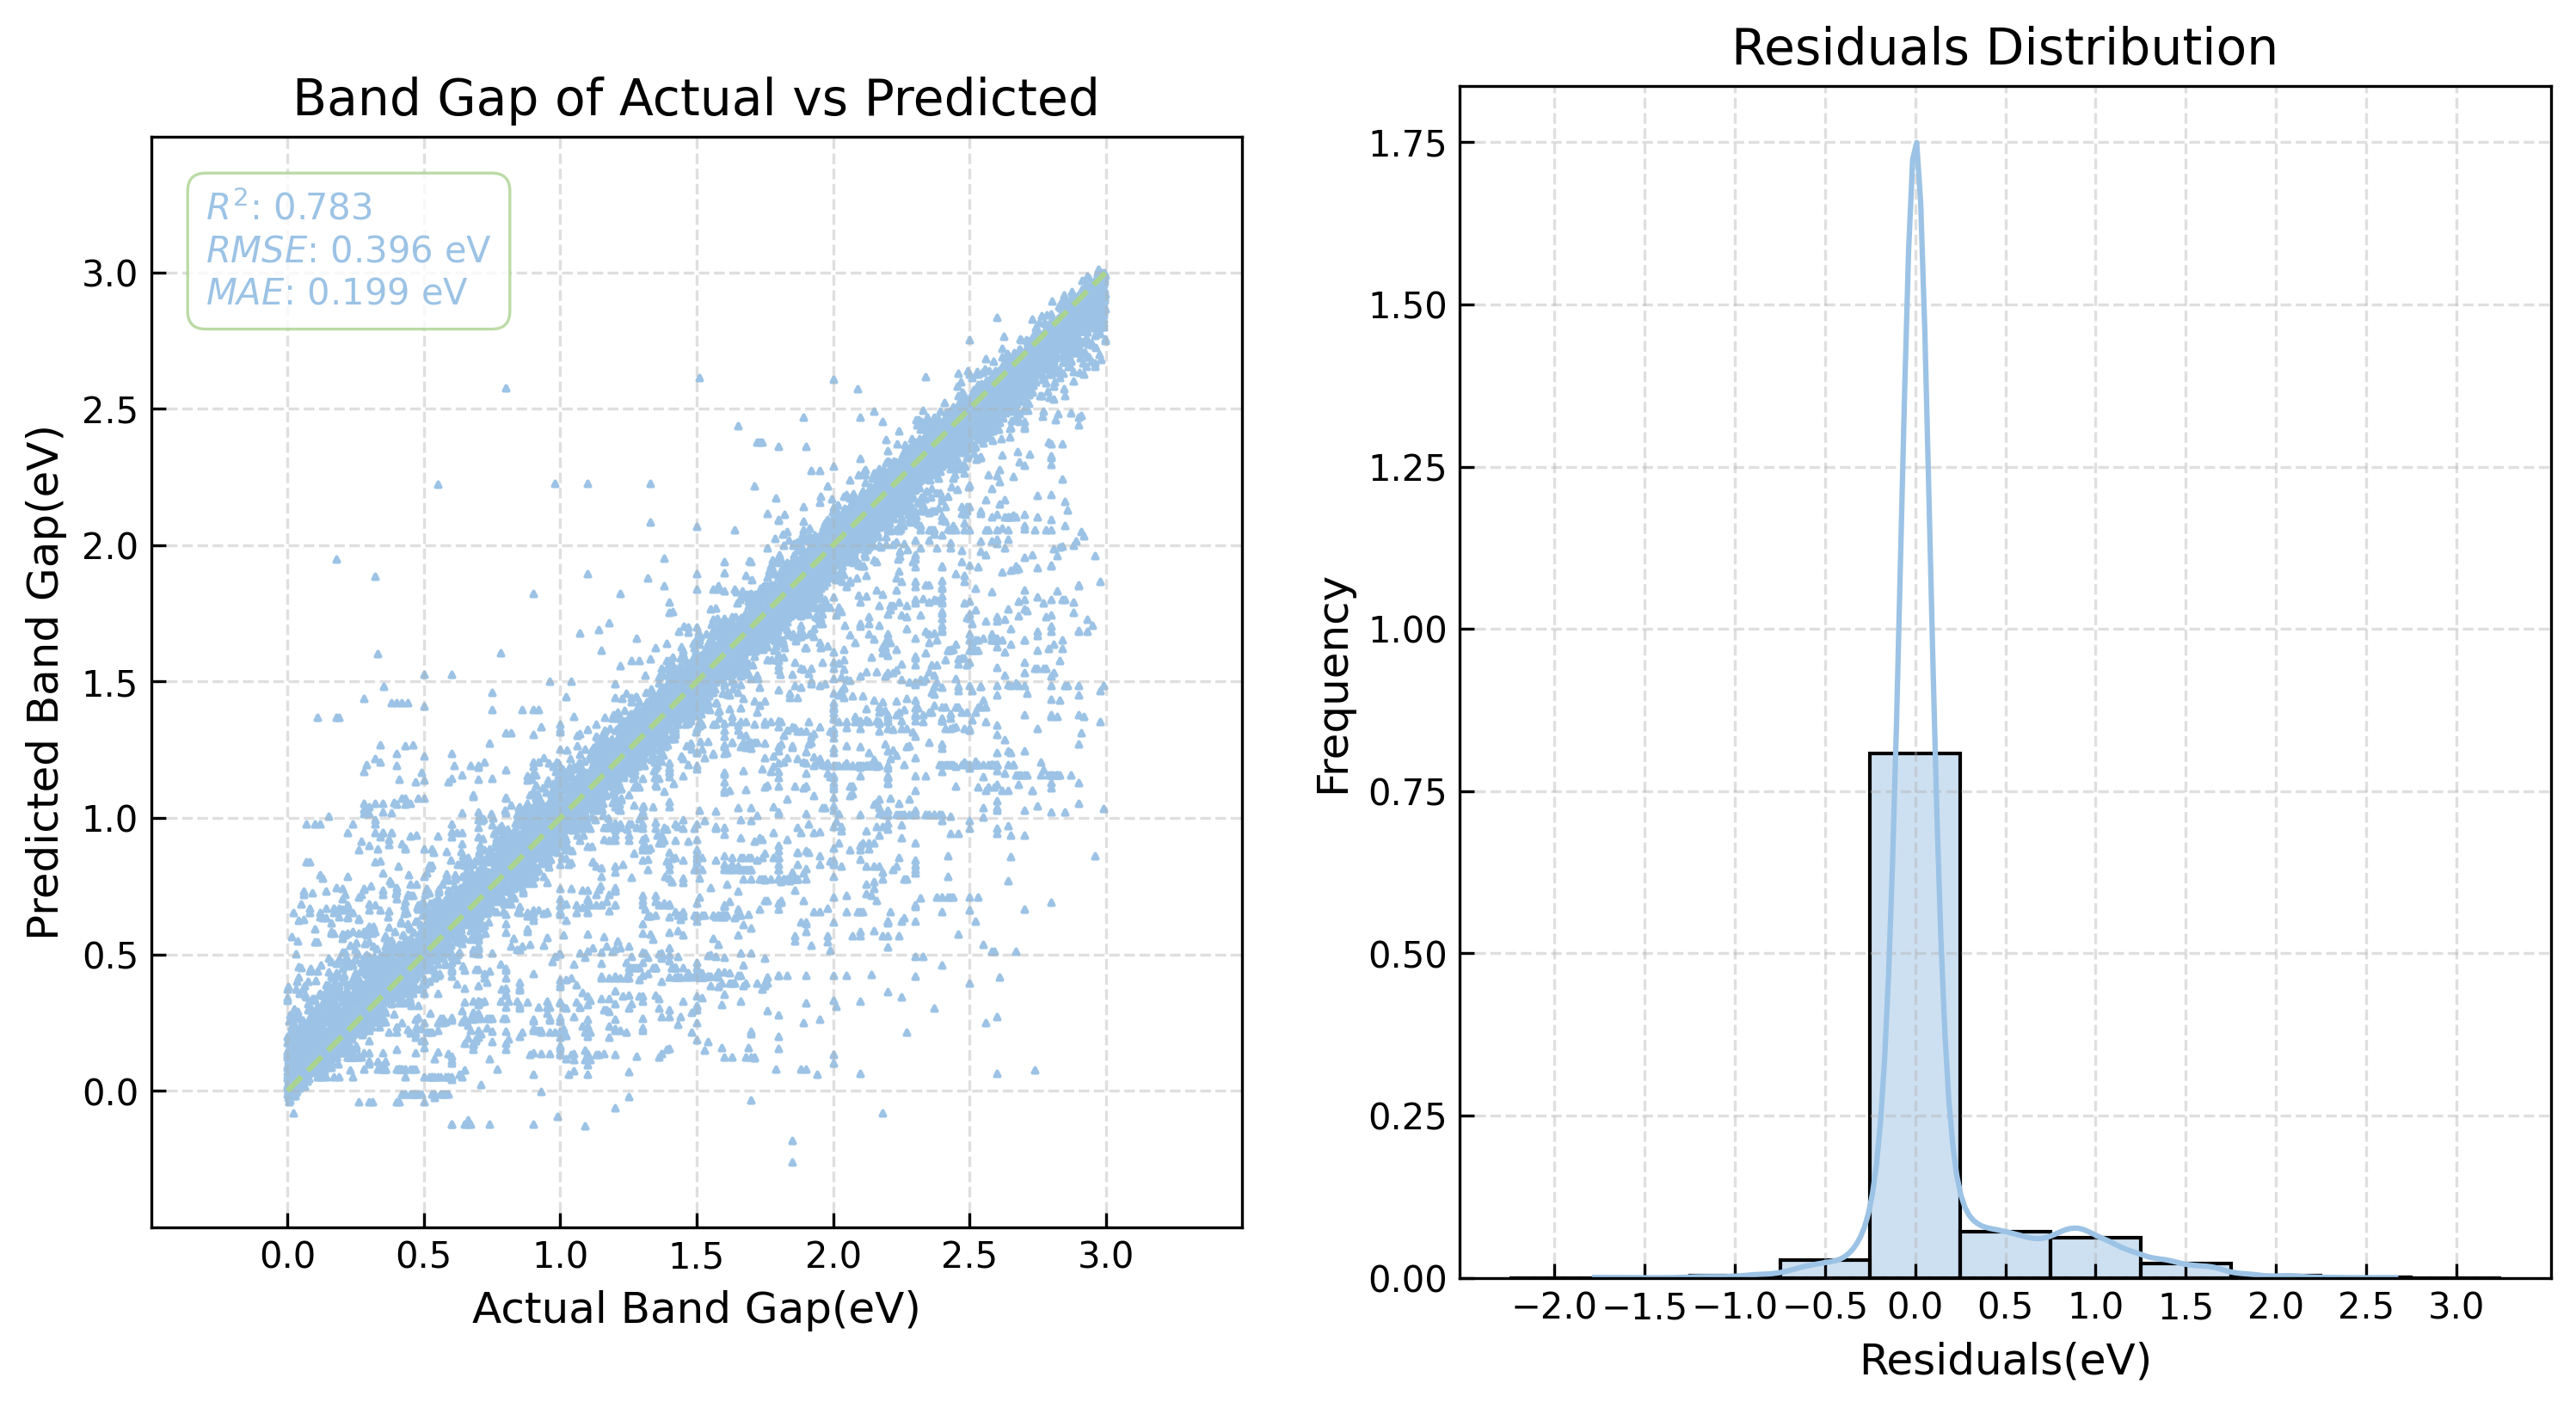


Model Evaluation Results:
Test set size: 10812
Test set: R²: 0.7826 RMSE: 0.3956 MAE: 0.1990 MAPE: 211.0904%
[Test MIX -> DFT] Evaluating Direct Mix XGBoost on DFT test set:


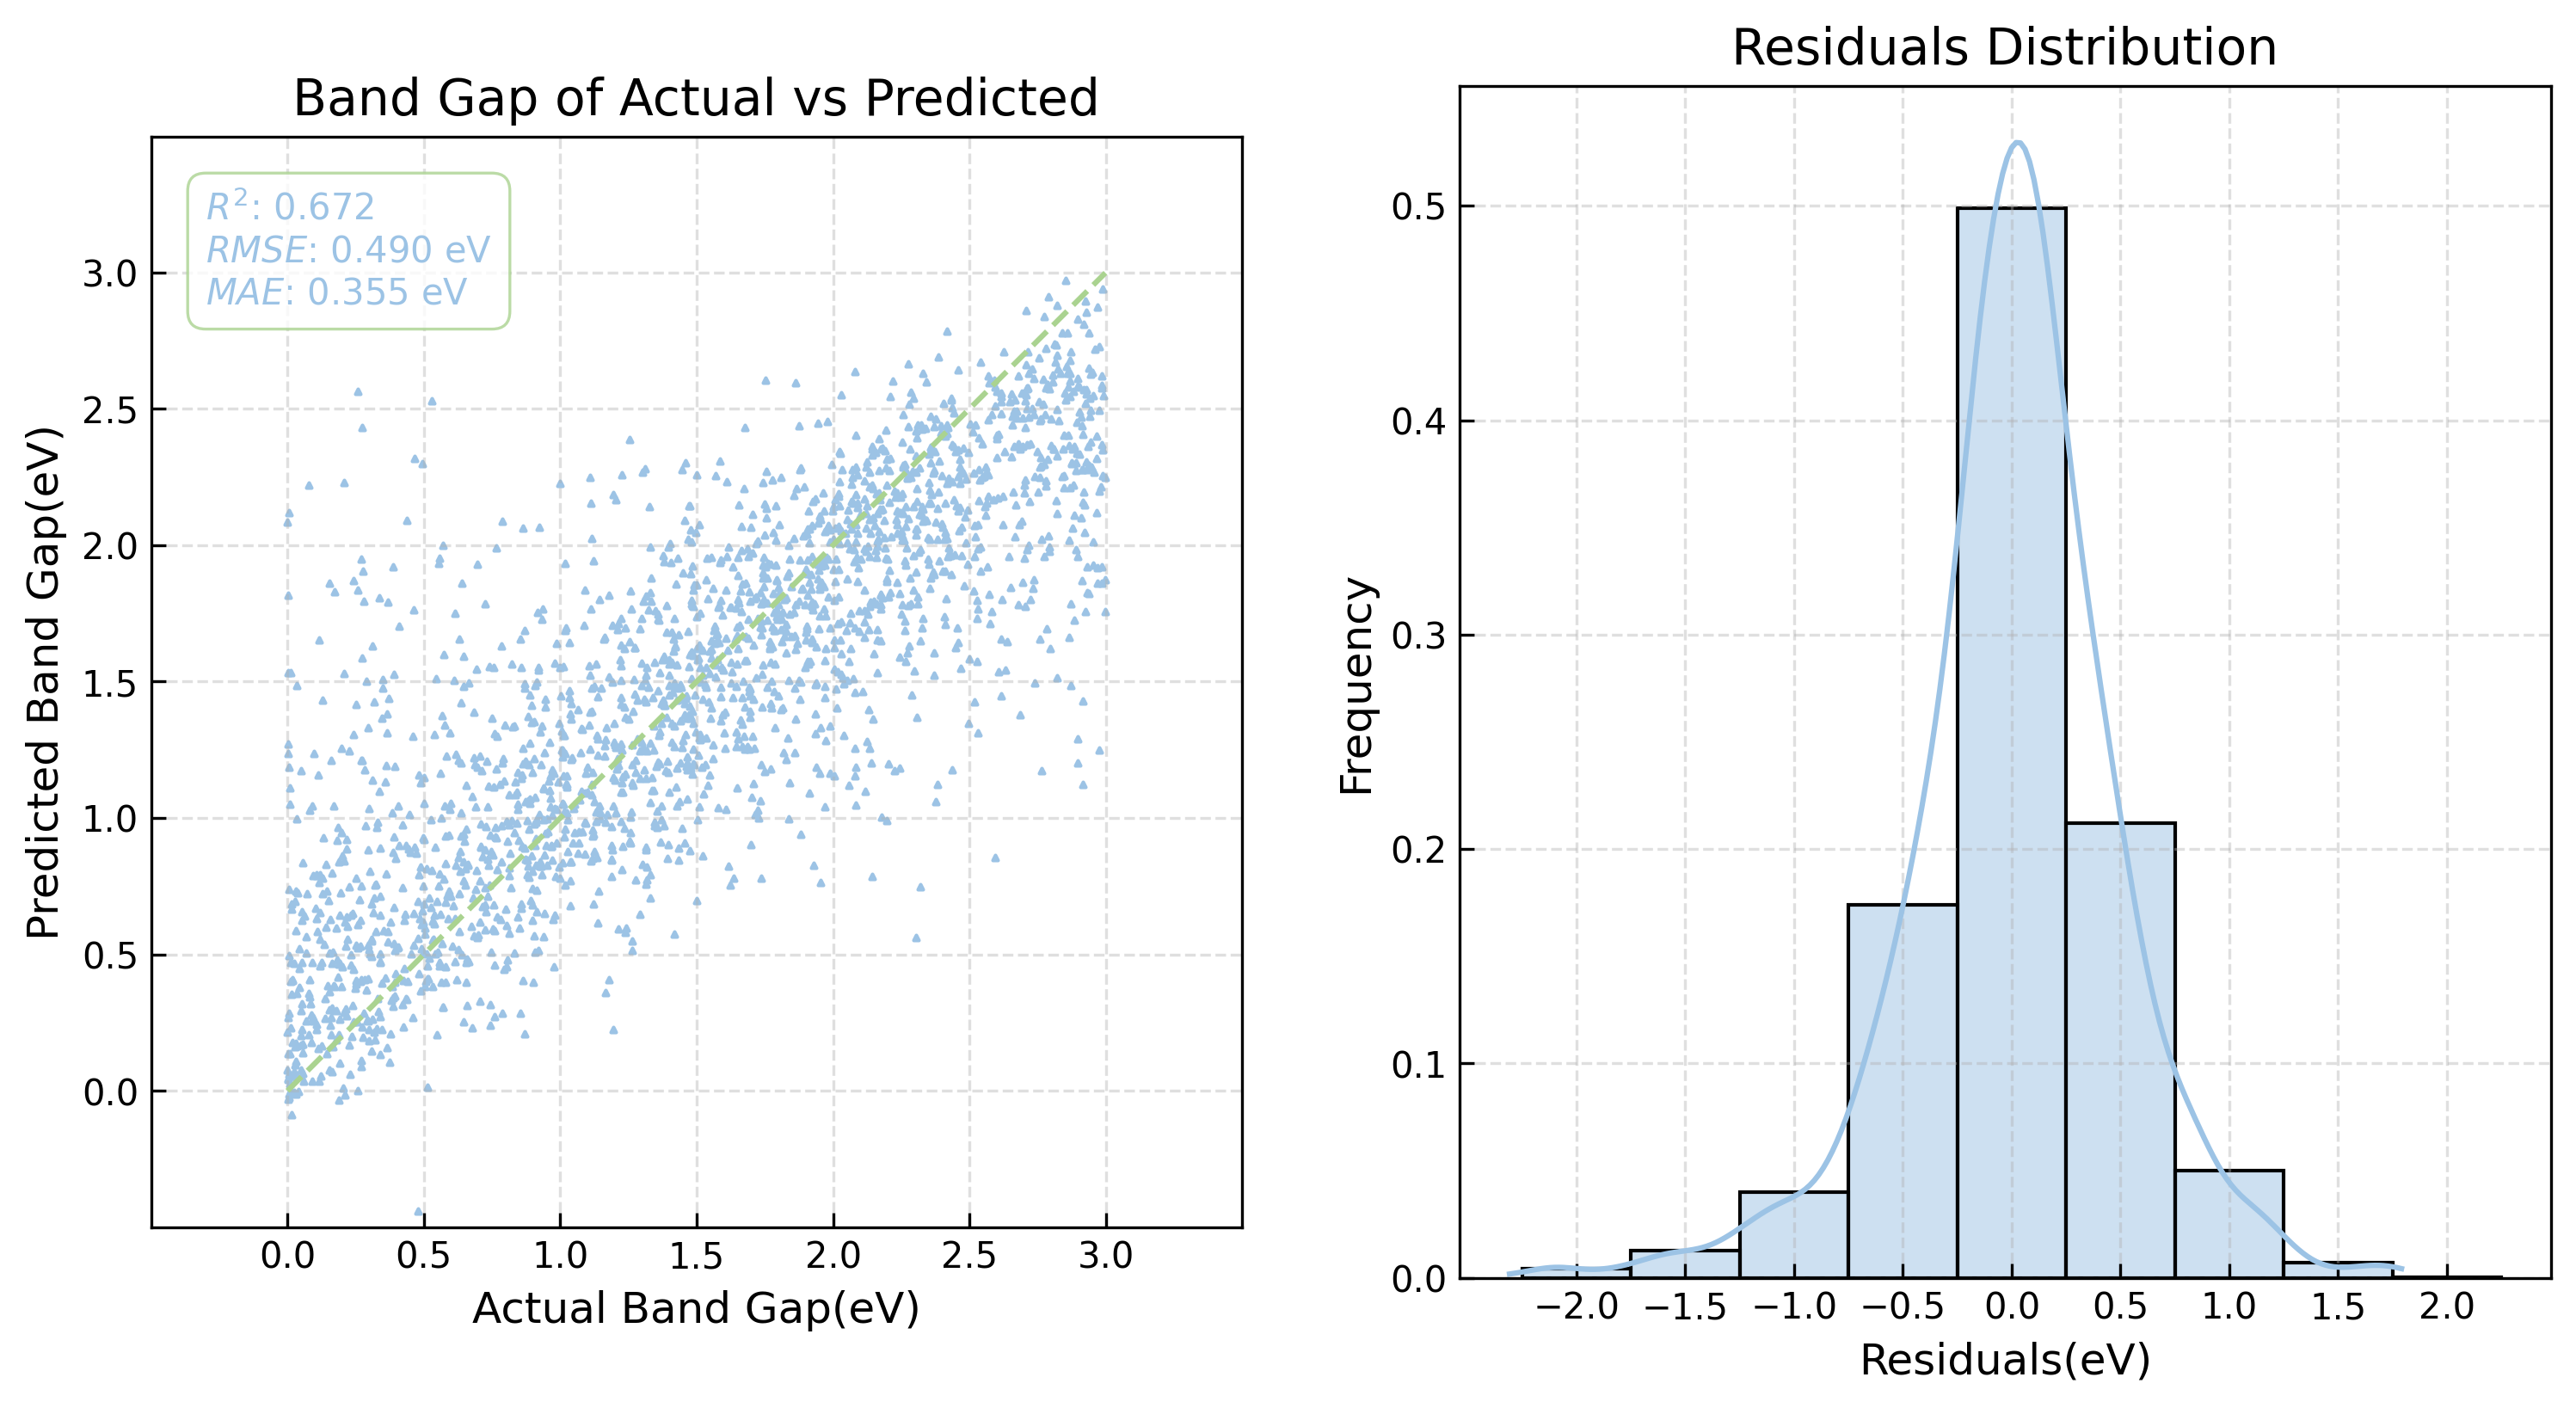


Model Evaluation Results:
Test set size: 2074
Test set: R²: 0.6719 RMSE: 0.4899 MAE: 0.3551 MAPE: 866.9767%
[Test MIX -> EXP] Evaluating Direct Mix XGBoost on EXP test set:


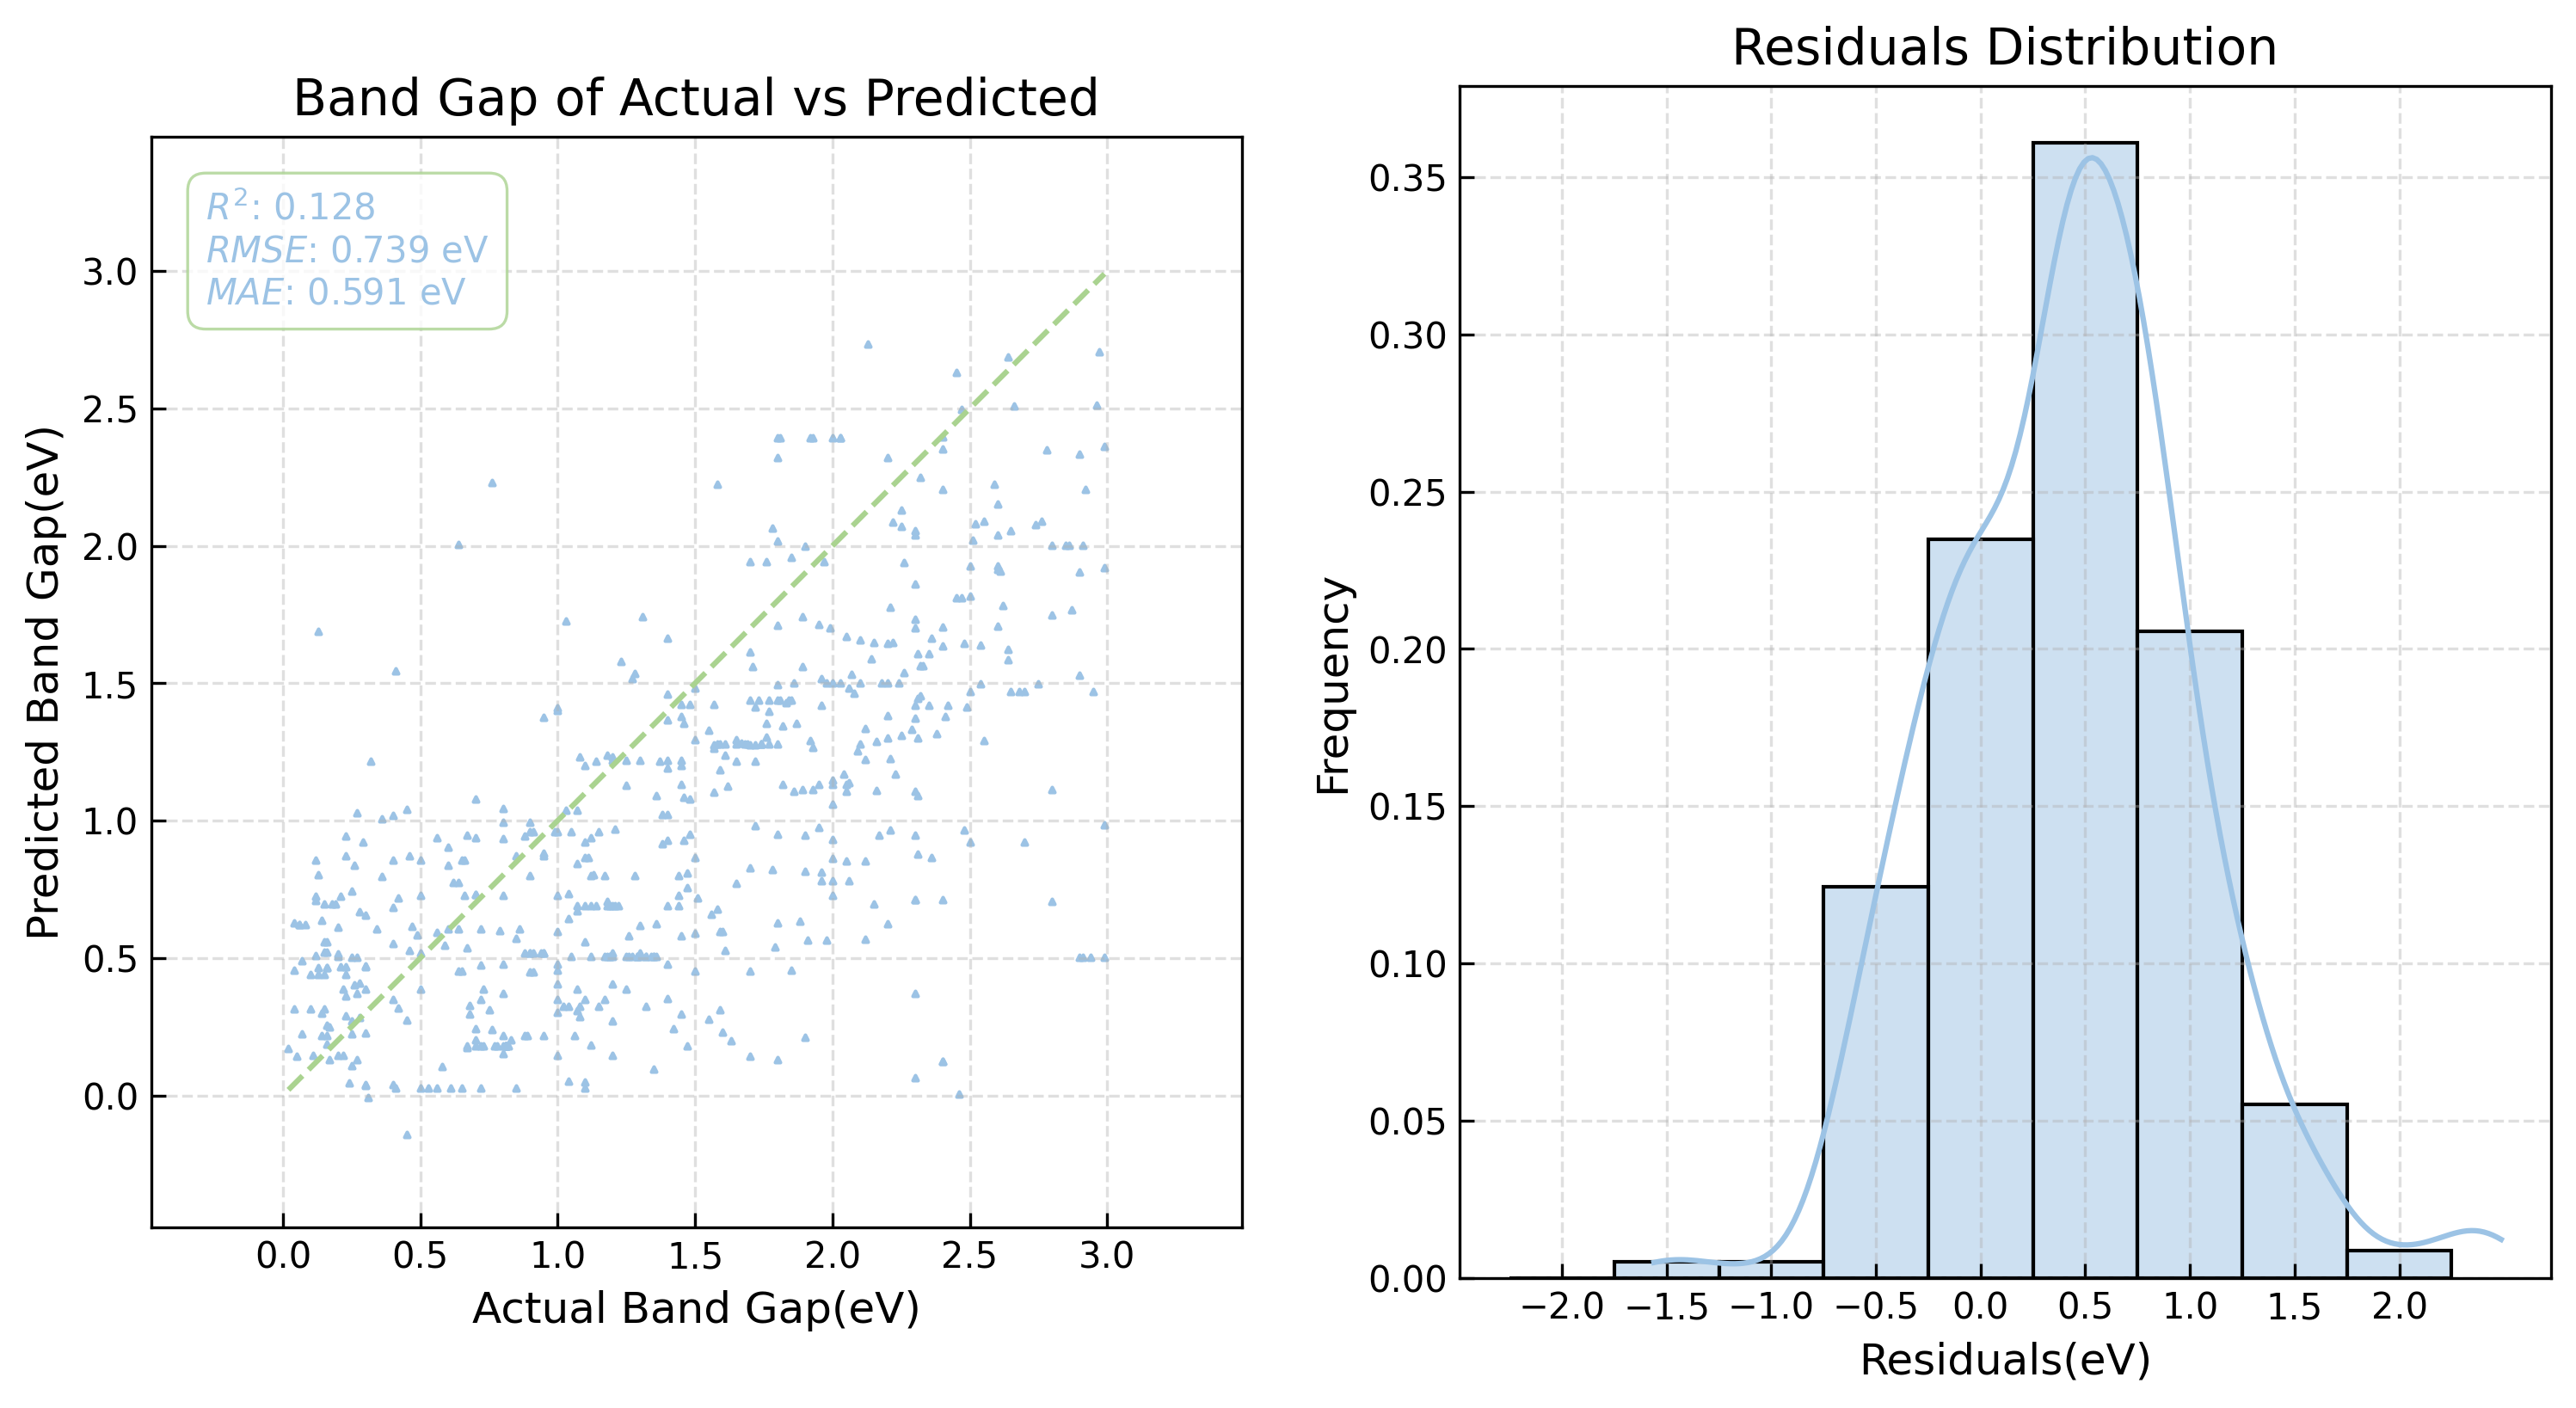


Model Evaluation Results:
Test set size: 586
Test set: R²: 0.1283 RMSE: 0.7388 MAE: 0.5908 MAPE: 71.4022%
[Test MIX -> MIX] Evaluating Direct Mix XGBoost on mixed test set:


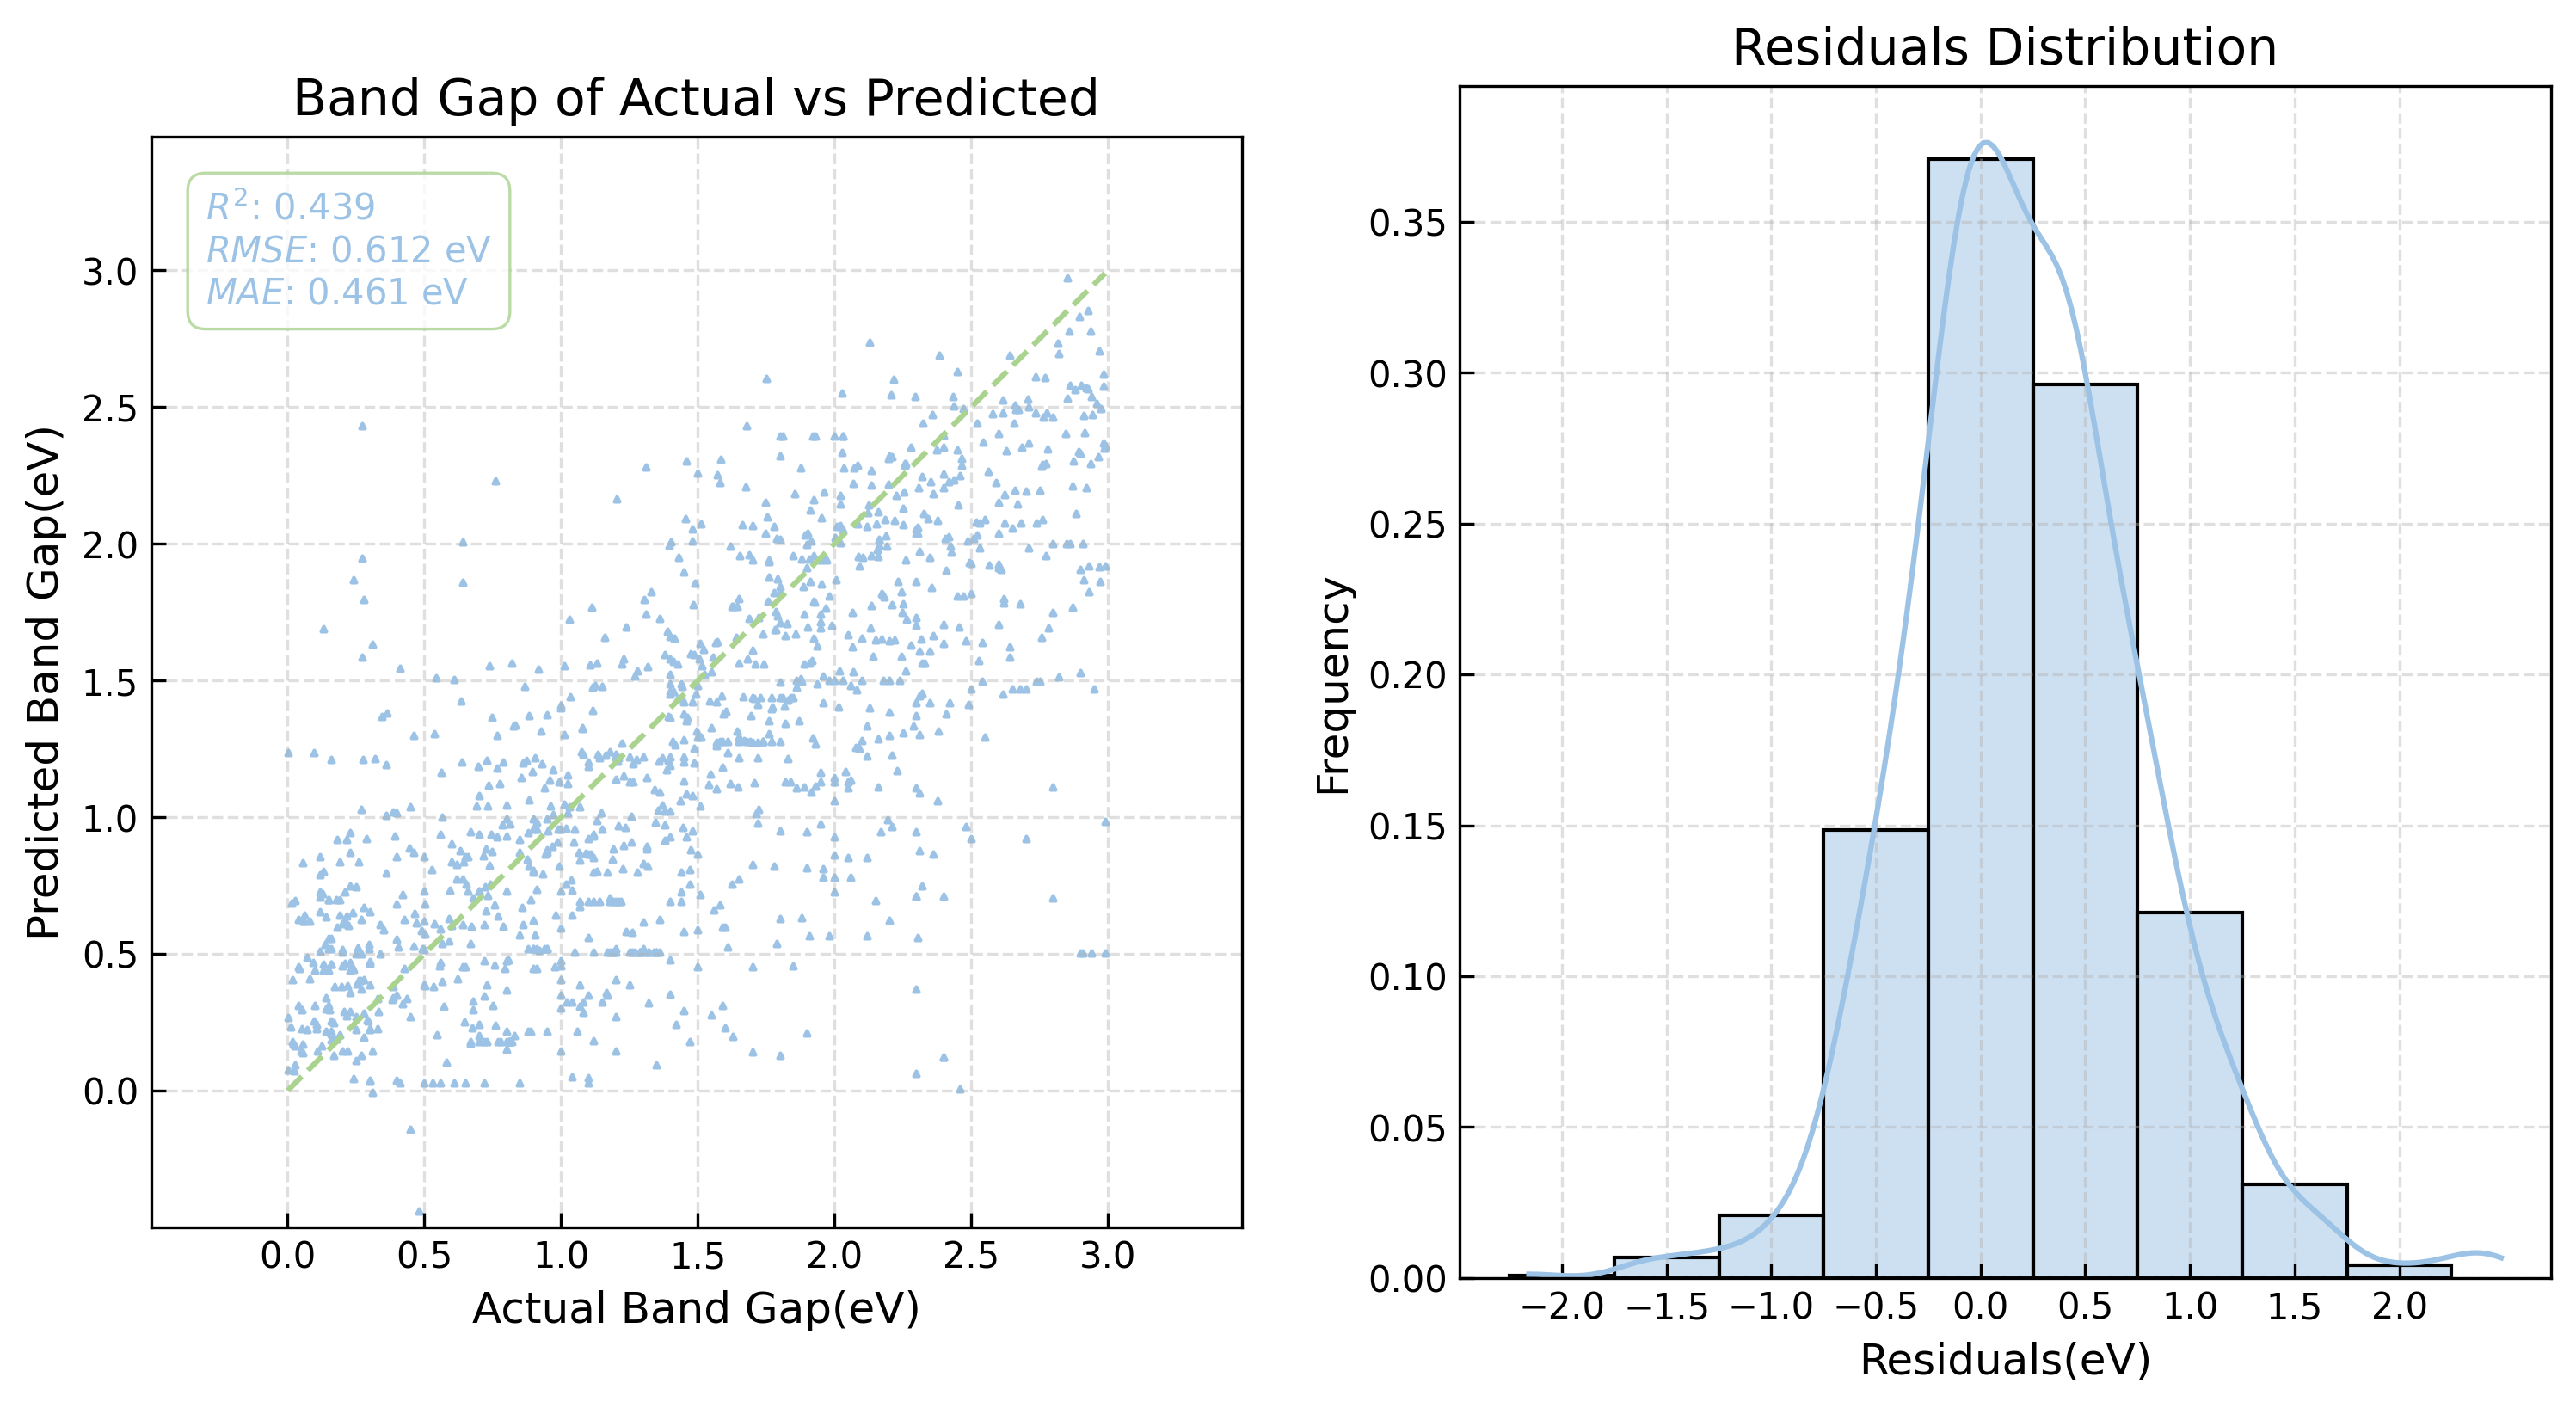


Model Evaluation Results:
Test set size: 1172
Test set: R²: 0.4392 RMSE: 0.6117 MAE: 0.4613 MAPE: 159.7727%


,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Direct Mix XGBoost,Train,mix,mix,0.782610,0.395588,0.198970
1,Direct Mix XGBoost,Test,mix,dft,0.671913,0.489908,0.355114
2,Direct Mix XGBoost,Test,mix,exp,0.128330,0.738788,0.590792
3,Direct Mix XGBoost,Test,mix,mix,0.439217,0.611707,0.461332


In [7]:
# 
MODEL_NAME = 'Direct Mix XGBoost'
# Train the model with the best hyperparameters on the entire training set
xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=0.5, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on mixed data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on Mix data:")
print("-" * 100)

model = SingleModel(xgboost_best, random_state=RANDOM_SEED)
model.train(dft_train_X, dft_train_y)

# evaluate on the train set
print(f"[Train_error] Evaluating {MODEL_NAME} on train set:")
metrics = model.evaluate(train_X, train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'mix',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test MIX -> DFT] Evaluating {MODEL_NAME} on DFT test set:")

metrics = model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test MIX -> EXP] Evaluating {MODEL_NAME} on EXP test set:")
metrics = model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the mixed test set
print(f"[Test MIX -> MIX] Evaluating {MODEL_NAME} on mixed test set:")
metrics = model.evaluate(mixed_test_X, mixed_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,    
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# save the model metrics to a csv file
model_metrics.to_csv(os.path.join(os.getcwd(), 'metrics', 'direct_mix_metrics.csv'), index=False)
model_metrics